# SAM Glomeruli Segmentation Evaluation on Kaggle Dataset

This notebook evaluates the performance of the Segment Anything Model (SAM) on the Kaggle Kidney dataset.
It loads the SAM model, iterates through all images in `kaggle_kidney_data/images_1024`, generates masks, and compares them with ground truth masks in `kaggle_kidney_data/masks_1024` using IoU and Dice scores.

In [8]:
import sys
import subprocess
import os

def install(package):
    print(f"Installing {package}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Check and install dependencies
required_packages = {
    "opencv-python": "cv2",
    "scikit-image": "skimage",
    "pandas": "pandas",
    "matplotlib": "matplotlib"
}

for package, import_name in required_packages.items():
    try:
        __import__(import_name)
    except ImportError:
        install(package)

try:
    from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
except ImportError:
    install("git+https://github.com/facebookresearch/segment-anything.git")
    from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from urllib.request import urlretrieve
from skimage import io, measure, morphology
from skimage.color import rgb2hed
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import cpu_count
import functools
import pandas as pd
import time

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1
CUDA available: False


## 1. Helper Functions (Loading Model, Processing)

In [9]:
def download_sam_checkpoint(model_type='vit_b', checkpoint_dir='checkpoints'):
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    checkpoint_urls = {
        'vit_h': 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth',
        'vit_l': 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth',
        'vit_b': 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth'
    }
    
    checkpoint_names = {
        'vit_h': 'sam_vit_h_4b8939.pth',
        'vit_l': 'sam_vit_l_0b3195.pth',
        'vit_b': 'sam_vit_b_01ec64.pth'
    }
    
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_names[model_type])
    
    if not os.path.exists(checkpoint_path):
        print(f"Downloading SAM {model_type} checkpoint...")
        urlretrieve(checkpoint_urls[model_type], checkpoint_path)
        print(f"Checkpoint downloaded to {checkpoint_path}")
    
    return checkpoint_path

def load_sam_model(model_type='vit_b', device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    print(f"Loading SAM model ({model_type}) on {device}...")
    checkpoint_path = download_sam_checkpoint(model_type)
    sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
    sam.to(device=device)
    return sam, device

def generate_glomeruli_prompts(image_rgb, num_points=50):
    hed = rgb2hed(image_rgb)
    hematoxylin = hed[:, :, 0]
    eosin = hed[:, :, 1]
    combined = (hematoxylin + eosin) / 2
    combined_norm = (combined - combined.min()) / (combined.max() - combined.min() + 1e-10)
    threshold = np.percentile(combined_norm, 60)
    binary = combined_norm > threshold
    kernel = morphology.disk(5)
    binary = morphology.binary_closing(binary, kernel)
    binary = morphology.binary_opening(binary, kernel)
    labeled = measure.label(binary)
    regions = measure.regionprops(labeled)
    points = []
    for region in regions:
        if 1000 <= region.area <= 50000:
            y, x = region.centroid
            points.append([int(x), int(y)])
    if len(points) < num_points:
        coords = np.column_stack(np.where(combined_norm > threshold))
        if len(coords) > 0:
            indices = np.random.choice(len(coords), min(num_points - len(points), len(coords)), replace=False)
            points.extend([[int(coords[i][1]), int(coords[i][0])] for i in indices])
    if len(points) > num_points:
        points = points[:num_points]
    points = np.array(points)
    labels = np.ones(len(points), dtype=np.int32)
    return points, labels

def _filter_mask_by_size(mask_data, min_size, max_size):
    area = mask_data['area'] if 'area' in mask_data else np.sum(mask_data['segmentation'])
    if min_size <= area <= max_size:
        return mask_data
    return None

def _filter_region(region, min_size, max_size):
    if min_size <= region.area <= max_size:
        if region.major_axis_length > 0:
            circularity = 4 * np.pi * region.area / (region.perimeter ** 2 + 1e-10)
            if circularity > 0.2:
                return region.label
    return None

## 2. Segmentation Logic (Optimized)

In [10]:
def segment_image_optimized(image_path, sam_model, device, use_auto_mask=True, min_size=1000, max_size=50000):
    # Load Image
    image_path_str = str(image_path)
    if image_path_str.lower().endswith(('.tif', '.tiff')):
        image = io.imread(image_path_str)
        if len(image.shape) == 2: image_rgb = np.stack([image]*3, axis=-1)
        elif len(image.shape) == 3 and image.shape[2] == 4: image_rgb = image[:,:,:3]
        else: image_rgb = image
        if image_rgb.dtype != np.uint8:
            image_rgb = (image_rgb * 255).astype(np.uint8) if image_rgb.max() <= 1.0 else image_rgb.astype(np.uint8)
    else:
        image = cv2.imread(image_path_str)
        if image is None:
            print(f"Failed to load image: {image_path_str}")
            return None, None
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    height, width = image_rgb.shape[:2]
    num_workers = min(5, cpu_count())

    if use_auto_mask:
        mask_generator = SamAutomaticMaskGenerator(
            model=sam_model,
            points_per_side=32,
            pred_iou_thresh=0.88,
            stability_score_thresh=0.95,
            crop_n_layers=1,
            crop_n_points_downscale_factor=2,
            min_mask_region_area=min_size,
        )
        masks = mask_generator.generate(image_rgb)
    else:
        points, labels = generate_glomeruli_prompts(image_rgb, num_points=100)
        predictor = SamPredictor(sam_model)
        predictor.set_image(image_rgb)
        masks = []
        batch_size = 20
        for i in range(0, len(points), batch_size):
            batch_points = points[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            if len(batch_points) == 0: continue
            mask, scores, _ = predictor.predict(point_coords=batch_points, point_labels=batch_labels, multimask_output=True)
            for j in range(len(batch_points)):
                best_idx = np.argmax(scores[j])
                masks.append({
                    'segmentation': mask[j][best_idx],
                    'score': scores[j][best_idx],
                    'area': np.sum(mask[j][best_idx])
                })

    # Filter masks by size
    filtered_masks = []
    if masks:
        with ThreadPoolExecutor(max_workers=num_workers) as executor:
            filter_func = functools.partial(_filter_mask_by_size, min_size=min_size, max_size=max_size)
            filtered_results = list(executor.map(filter_func, masks))
        filtered_masks = [m for m in filtered_results if m is not None]
        filtered_masks.sort(key=lambda x: x['area'], reverse=True)

    # Combine masks (simple non-max suppression)
    glomeruli_mask = np.zeros((height, width), dtype=bool)
    for mask_data in filtered_masks:
        mask = mask_data['segmentation']
        area = mask_data['area']
        overlap = np.sum(glomeruli_mask & mask) / area if area > 0 else 0
        if overlap < 0.4:
            glomeruli_mask |= mask

    # Final Region Filtering
    labeled_glomeruli = measure.label(glomeruli_mask)
    regions = measure.regionprops(labeled_glomeruli)
    if regions:
        with ThreadPoolExecutor(max_workers=num_workers) as executor:
            filter_func = functools.partial(_filter_region, min_size=min_size, max_size=max_size)
            valid_labels = list(executor.map(filter_func, regions))
        valid_labels = set([l for l in valid_labels if l is not None])
        final_mask = np.isin(labeled_glomeruli, list(valid_labels))
    else:
        final_mask = np.zeros_like(glomeruli_mask, dtype=bool)

    return final_mask, image_rgb

## 3. Evaluation Metrics

In [11]:
def calculate_iou(pred_mask, gt_mask):
    pred_mask = pred_mask.astype(bool)
    gt_mask = gt_mask.astype(bool)
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    return intersection / union

def calculate_dice(pred_mask, gt_mask):
    pred_mask = pred_mask.astype(bool)
    gt_mask = gt_mask.astype(bool)
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    sum_masks = pred_mask.sum() + gt_mask.sum()
    if sum_masks == 0:
        return 1.0
    return 2.0 * intersection / sum_masks

## 4. Main Evaluation Loop

This section iterates through the dataset, runs SAM, and compares with ground truth.

In [12]:
def evaluate_dataset(images_dir, masks_dir, limit=None):
    images_path = Path(images_dir)
    masks_path = Path(masks_dir)
    
    image_files = sorted(list(images_path.glob("*.png")) + list(images_path.glob("*.tif")))
    if limit:
        image_files = image_files[:limit]
    
    print(f"Found {len(image_files)} images to evaluate.")
    
    if len(image_files) == 0:
        return pd.DataFrame()

    # Load Model Once
    sam_model, device = load_sam_model(model_type='vit_b')
    
    results = []
    
    for i, img_path in enumerate(image_files):
        # Find corresponding mask
        mask_path = masks_path / img_path.name
        
        if not mask_path.exists():
            print(f"Warning: Mask not found for {img_path.name}. Skipping.")
            continue
        
        print(f"[{i+1}/{len(image_files)}] Processing {img_path.name}...", end="", flush=True)
        
        # Run Segmentation
        start_time = time.time()
        # Use use_auto_mask=True for full automatic segmentation (slower but potentially more accurate)
        pred_mask, image_rgb = segment_image_optimized(img_path, sam_model, device, use_auto_mask=True)
        seg_time = time.time() - start_time
        
        if pred_mask is None:
            print(" Failed to segment.")
            continue

        # Load GT Mask
        gt_mask_img = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        gt_mask = gt_mask_img > 0
        
        # Calculate Metrics
        iou = calculate_iou(pred_mask, gt_mask)
        dice = calculate_dice(pred_mask, gt_mask)
        
        results.append({
            'filename': img_path.name,
            'iou': iou,
            'dice': dice,
            'seg_time': seg_time,
            'num_glomeruli_pred': measure.label(pred_mask).max(),
            'num_glomeruli_gt': measure.label(gt_mask).max()
        })
        
        print(f" IoU: {iou:.4f}, Dice: {dice:.4f}, Time: {seg_time:.2f}s")
        
        # Visualize first 3 results
        if i < 3:
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            ax[0].imshow(image_rgb)
            ax[0].set_title("Image")
            ax[0].axis('off')
            
            ax[1].imshow(gt_mask, cmap='gray')
            ax[1].set_title("Ground Truth")
            ax[1].axis('off')
            
            ax[2].imshow(pred_mask, cmap='gray')
            ax[2].set_title(f"SAM Prediction (IoU: {iou:.2f})")
            ax[2].axis('off')
            plt.show()
    
    return pd.DataFrame(results)

Found 5 images to evaluate.
Loading SAM model (vit_b) on cpu...
[1/5] Processing SAS_21883_001_0.png... IoU: 1.0000, Dice: 1.0000, Time: 72.79s


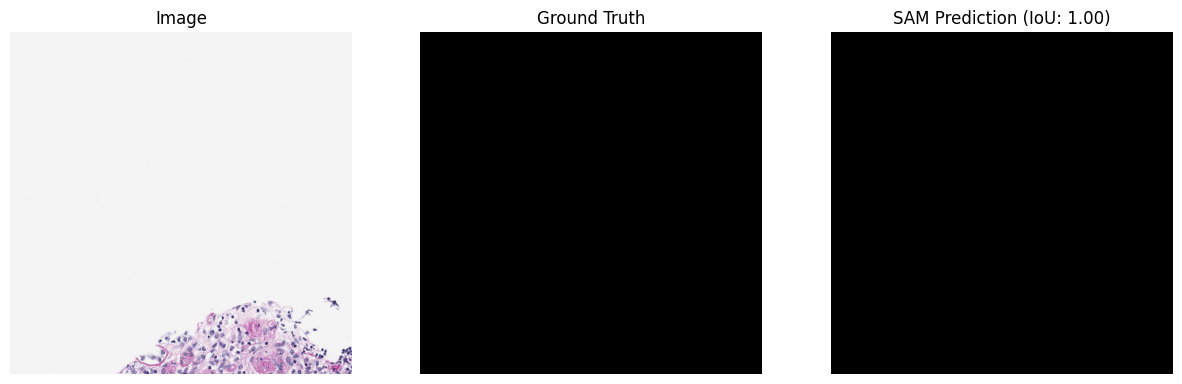

[2/5] Processing SAS_21883_001_1.png... IoU: 0.0000, Dice: 0.0000, Time: 72.54s


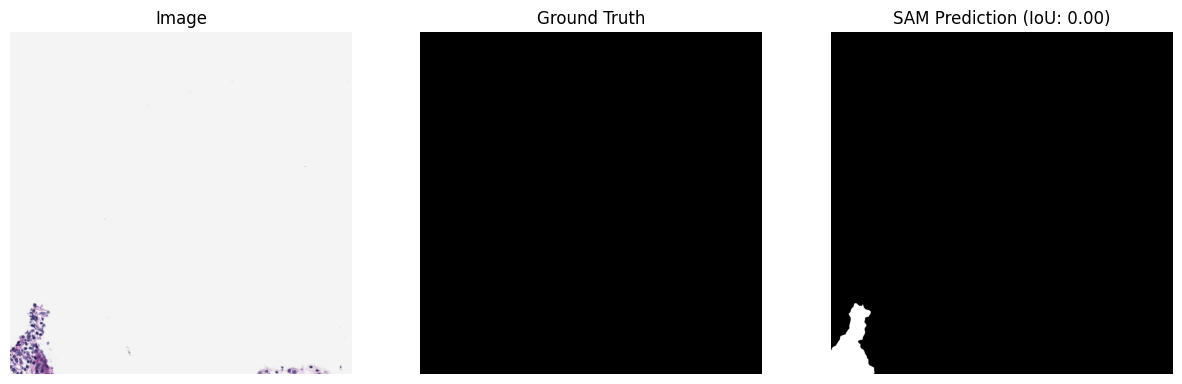

[3/5] Processing SAS_21883_001_10.png... IoU: 0.0115, Dice: 0.0228, Time: 69.86s


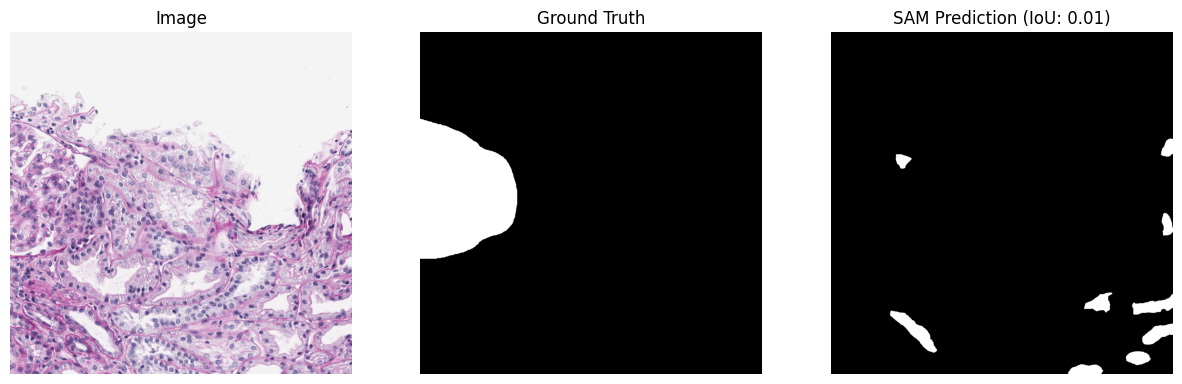

[4/5] Processing SAS_21883_001_100.png... IoU: 0.0000, Dice: 0.0000, Time: 69.19s
[5/5] Processing SAS_21883_001_101.png... IoU: 0.0000, Dice: 0.0000, Time: 72.57s

Average Metrics:
iou          0.202306
dice         0.204560
seg_time    71.389865
dtype: float64


In [13]:
# Run Evaluation
# Set limit=None to run on full dataset (might take a long time)
images_dir = "kaggle_kidney_data/images_1024"
masks_dir = "kaggle_kidney_data/masks_1024"

if os.path.exists(images_dir):
    # Running on first 5 for demonstration. Remove limit=5 to run on all.
    df_results = evaluate_dataset(images_dir, masks_dir, limit=5)
    
    if not df_results.empty:
        print("\nAverage Metrics:")
        print(df_results[['iou', 'dice', 'seg_time']].mean())
        
        # Save results
        df_results.to_csv("sam_evaluation_results.csv", index=False)
    else:
        print("No results generated.")
else:
    print(f"Directory {images_dir} not found. Please check paths.")